In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE  # To handle class imbalance
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [ ]:
file_path = '/content/Dataset 1 _ Pima Indians diabetes dataset (PIDD).csv'
df = pd.read_csv(file_path)

In [ ]:
df.replace(0, np.nan, inplace=True)

df.fillna(df.mean(), inplace=True)


In [ ]:
df.head()

,Pregnancies,Glucose,Blood pressure,Skin thickness,Insulin,Body mass index,Diabetes pedigree function,Age,Outcome
0,6.000000,148.0,72.0,35.00000,155.548223,33.6,0.627,50,1.0
1,1.000000,85.0,66.0,29.00000,155.548223,26.6,0.351,31,1.0
2,8.000000,183.0,64.0,29.15342,155.548223,23.3,0.672,32,1.0
3,1.000000,89.0,66.0,23.00000,94.000000,28.1,0.167,21,1.0
4,4.494673,137.0,40.0,35.00000,168.000000,43.1,2.288,33,1.0


In [ ]:
df.isnull().sum()

,0
Pregnancies,0
Glucose,0
Blood pressure,0
Skin thickness,0
Insulin,0
Body mass index,0
Diabetes pedigree function,0
Age,0
Outcome,0


In [ ]:
df.shape

(768, 9)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Pregnancies                 768 non-null    float64
 1   Glucose                     768 non-null    float64
 2   Blood pressure              768 non-null    float64
 3   Skin thickness              768 non-null    float64
 4   Insulin                     768 non-null    float64
 5   Body mass index             768 non-null    float64
 6   Diabetes pedigree function  768 non-null    float64
 7   Age                         768 non-null    int64  
 8   Outcome                     768 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 54.1 KB


In [ ]:
def remove_outliers(data, columns):
    for column in columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return data

In [ ]:
columns_to_check = df.columns[:-1]  # Exclude the 'Outcome' column
df = remove_outliers(df, columns_to_check)

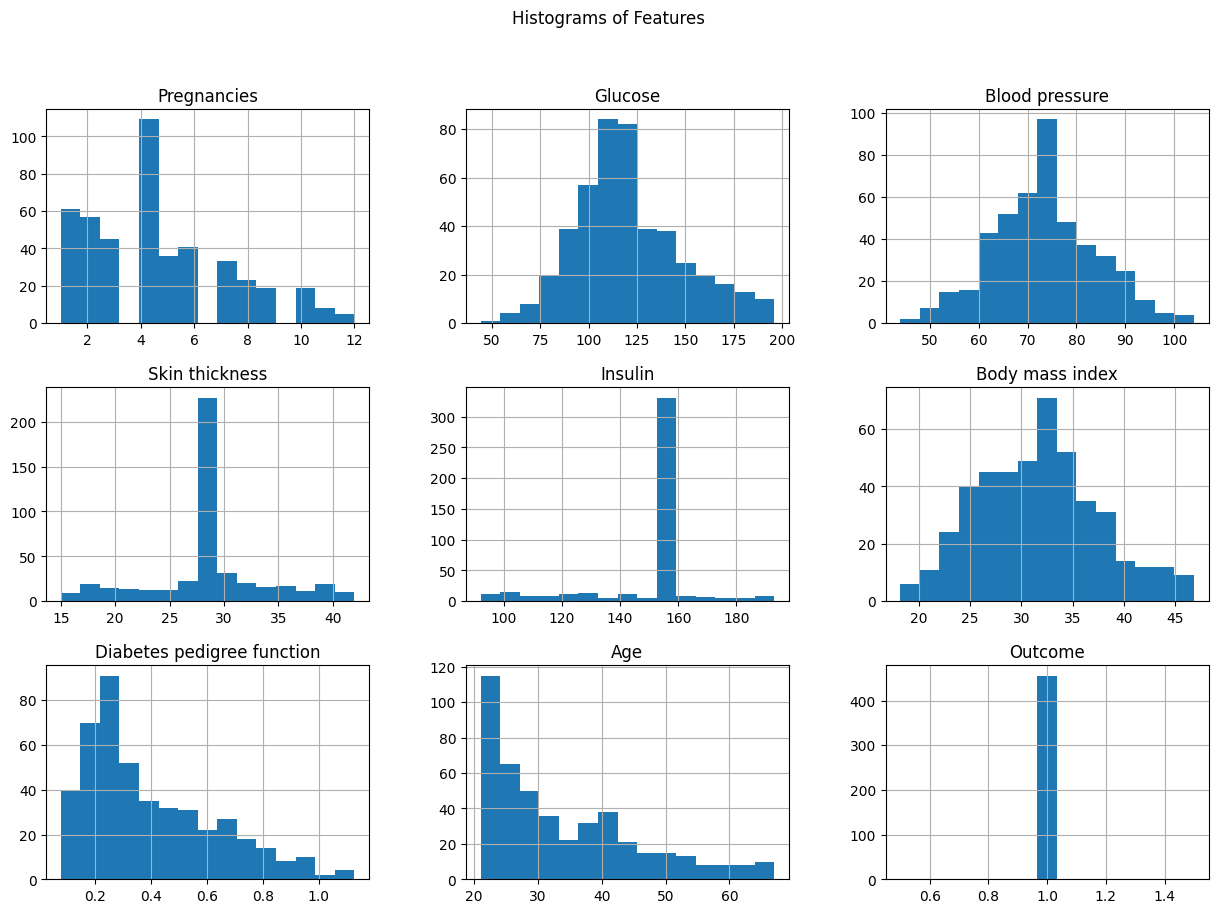

In [ ]:

df.hist(bins=15, figsize=(15, 10), layout=(3, 3))
plt.suptitle('Histograms of Features')
plt.show()

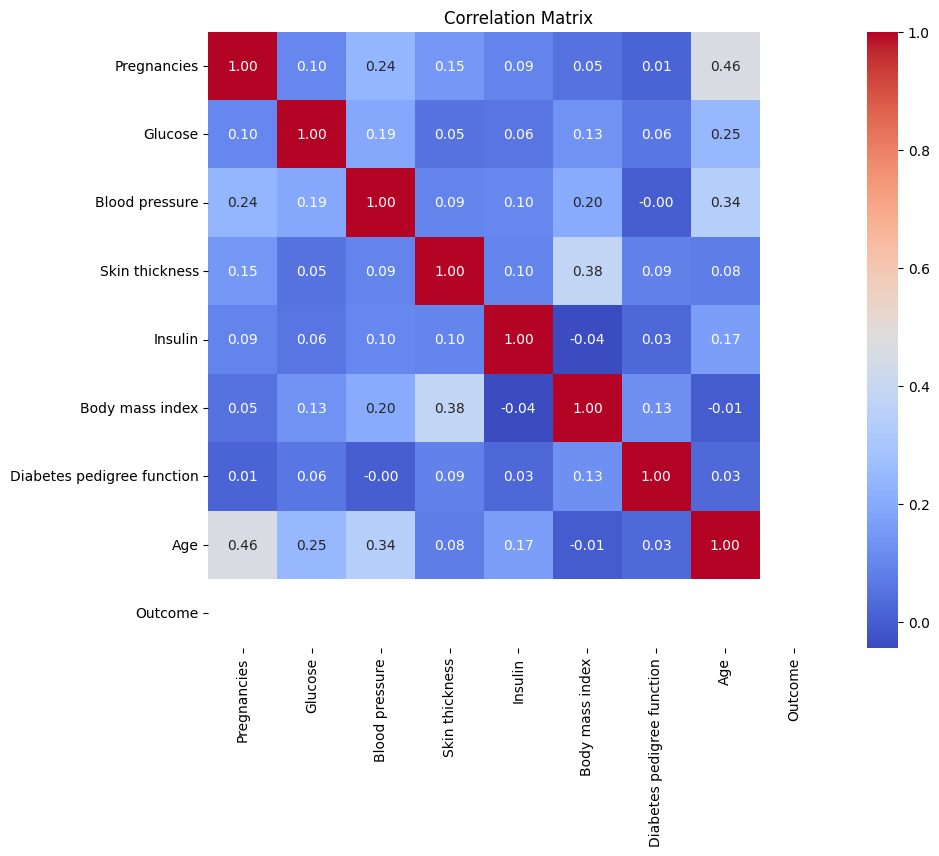

In [ ]:
plt.figure(figsize=(10, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

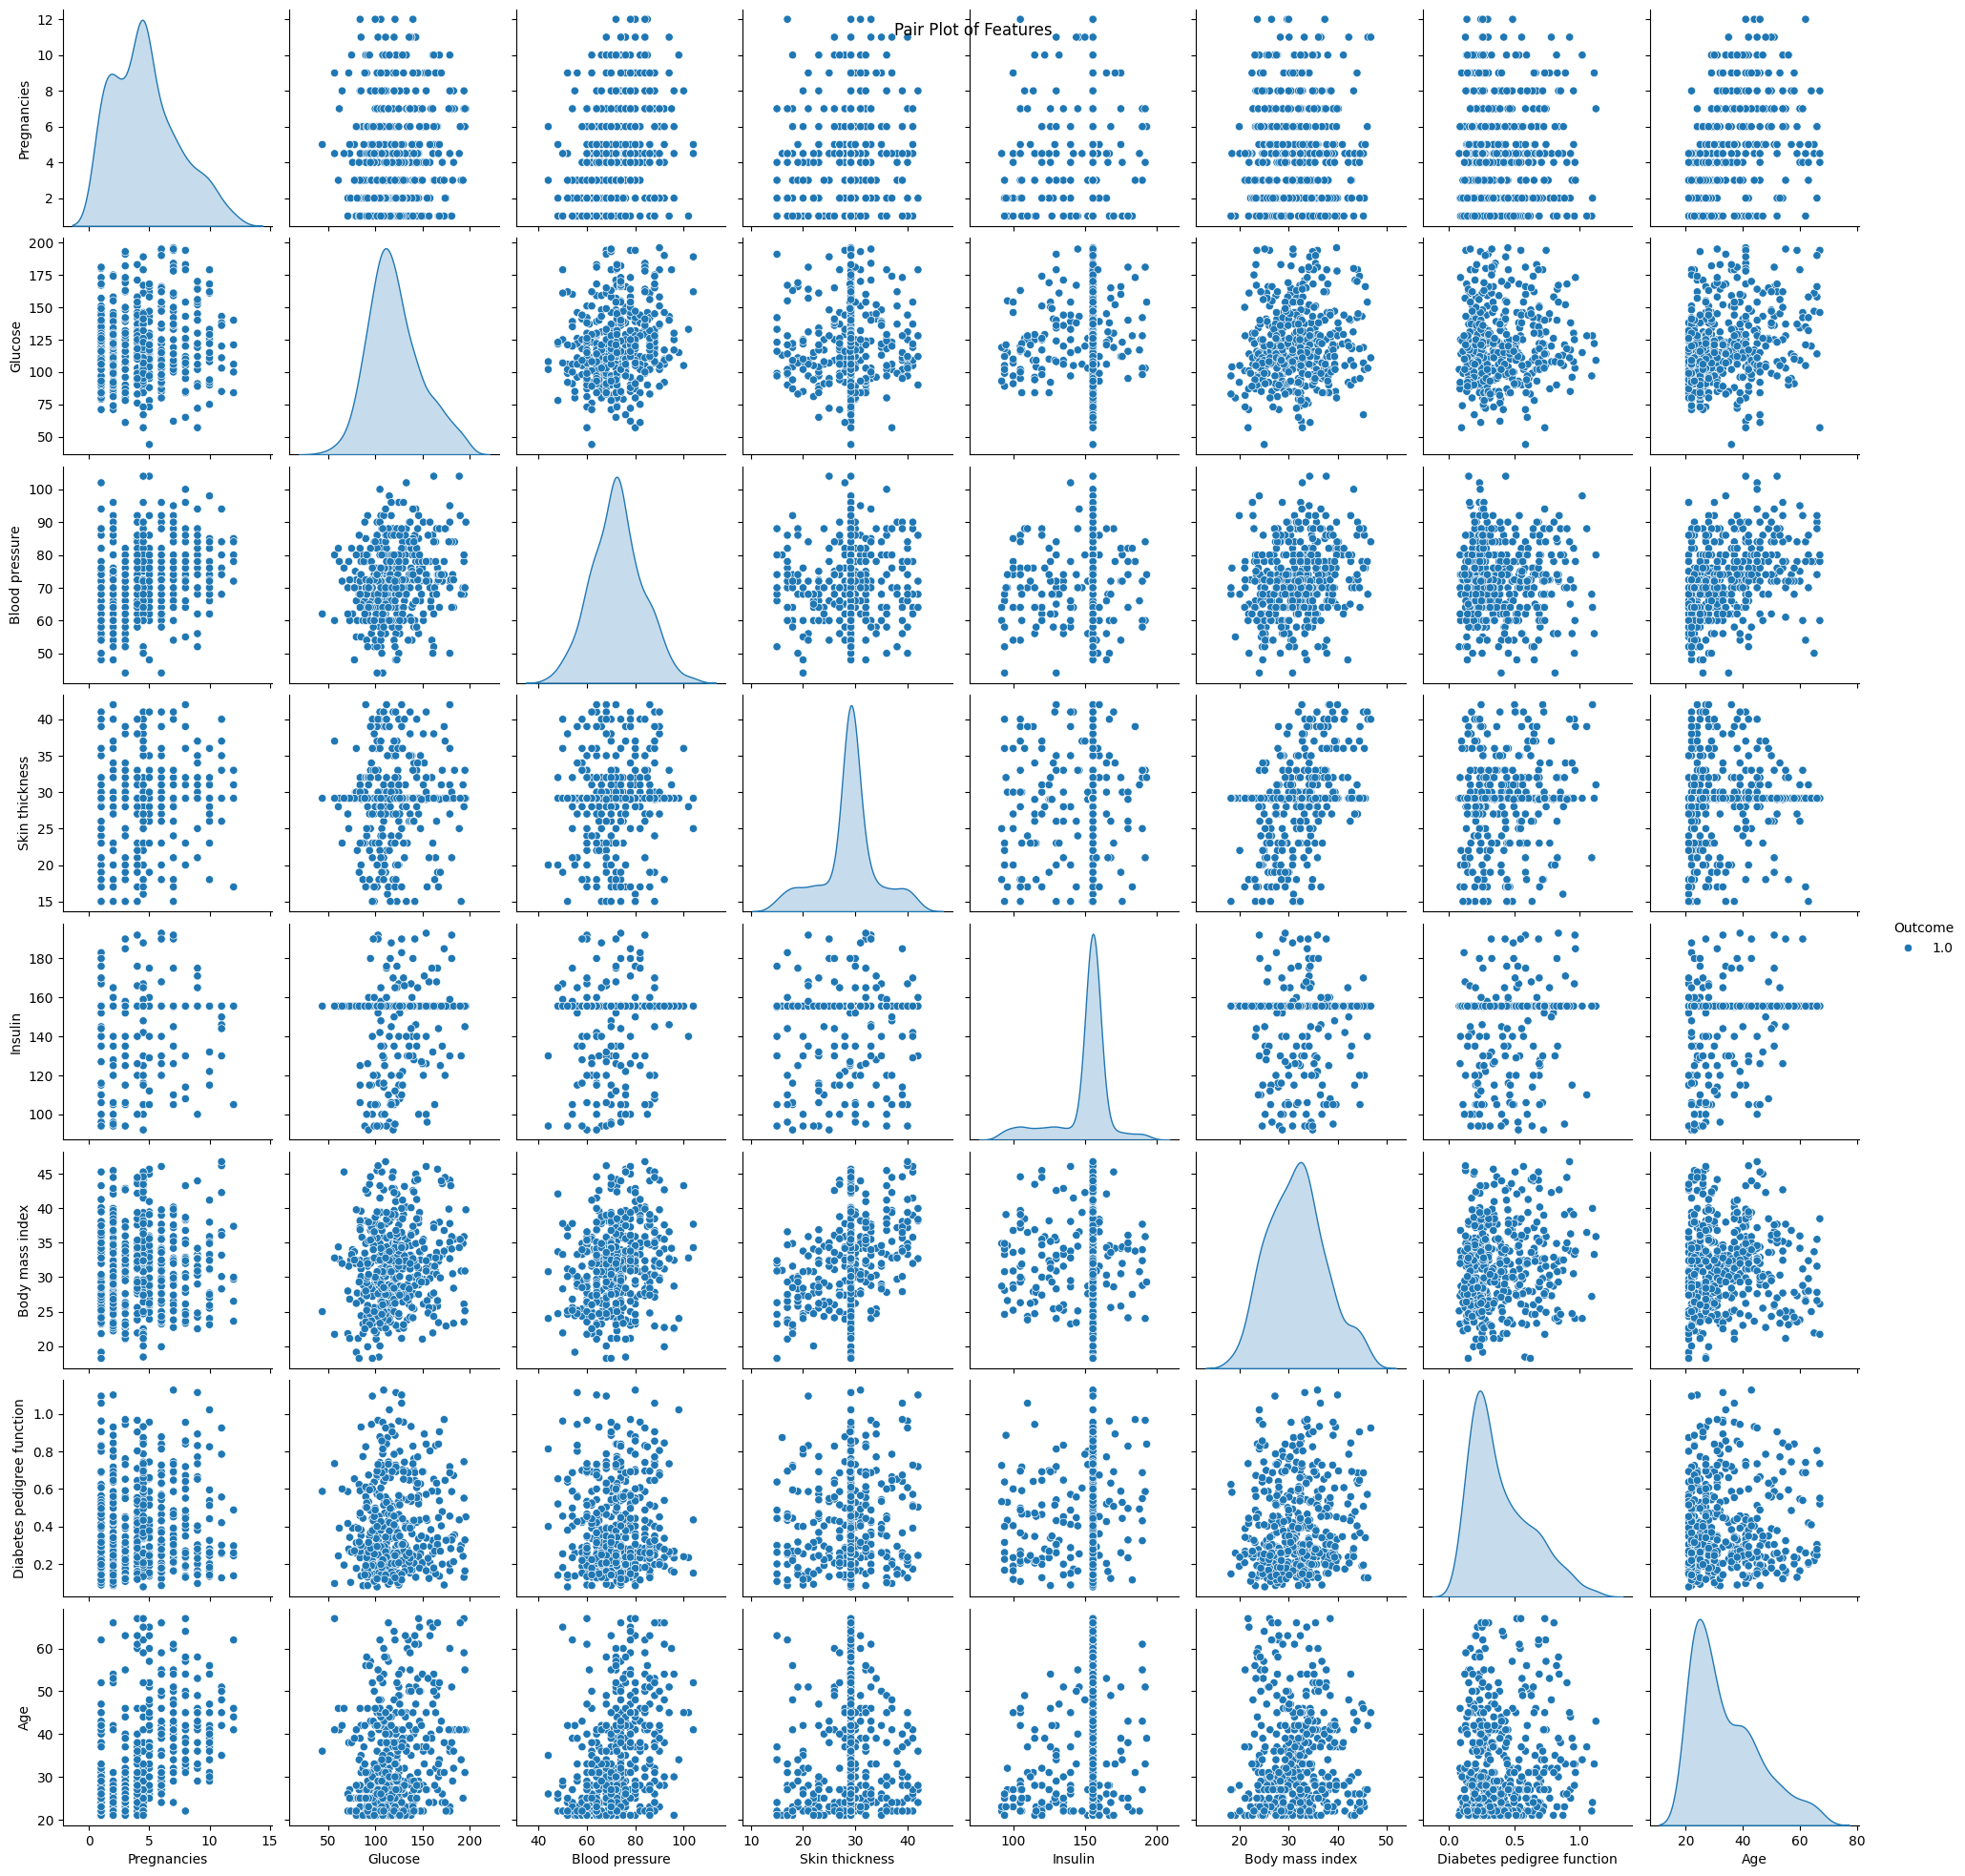

In [ ]:
sns.pairplot(df, hue='Outcome')
plt.suptitle('Pair Plot of Features')
plt.show()

In [ ]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

In [ ]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

In [ ]:
# Check class distribution in the full dataset
print("Class distribution in the full dataset:")
print(df['Outcome'].value_counts())

Class distribution in the full dataset:
Outcome
1.0    456
Name: count, dtype: int64


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)


In [ ]:
# Check class distribution in the training and test sets
print("Class distribution in the training set:")
print(y_train.value_counts())
print("Class distribution in the test set:")
print(y_test.value_counts())

Class distribution in the training set:
Outcome
1.0    364
Name: count, dtype: int64
Class distribution in the test set:
Outcome
1.0    92
Name: count, dtype: int64


In [ ]:
# Handle class imbalance using SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

ValueError: The target 'y' needs to have more than 1 class. Got 1 class instead

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [ ]:
best_params = grid_search.best_params_
print(f'Best parameters found: {best_params}')

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [ ]:
best_model = grid_search.best_estimator_
best_model.fit(X_train_scaled, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

In [ ]:
y_pred = best_model.predict(X_test_scaled)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [ ]:
print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Accuracy: 1.0
Confusion Matrix:
[[92]]
Classification Report:
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        92

    accuracy                           1.00        92
   macro avg       1.00      1.00      1.00        92
weighted avg       1.00      1.00      1.00        92



In [ ]:
input_data = (4,150,60,26,110,25.5,1.128,55)

input_data_as_numpy_array = np.asarray(input_data)

input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)

prediction = best_model.predict(input_data_reshaped)
print(prediction)

print("The person has Diabetes" if prediction[0] else "The person does not have Diabetes")

[1.]
The person has Diabetes


In [ ]:
# Predicting the outcomes on the test data
y_pred = best_model.predict(X_test_scaled)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)

# Printing the accuracy
print(f'Accuracy of the model: {accuracy * 100:.2f}%')


Accuracy of the model: 100.00%


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Predicting the outcomes on the test data
y_pred = best_model.predict(X_test_scaled)

# Calculating Precision, Recall, and F1-Score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)



# Printing the evaluation metrics
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')


Precision: 1.00
Recall: 1.00
F1 Score: 1.00


Unable to apply SMOTE or undersampling due to lack of class diversity.
